In [ ]:
import torch
import torch.nn as nn
import torch.functional as F

In [ ]:
# difference between regular segment encoder and decoder
# and unet model is skip connection that introduce the
# high level features to decoder layers

# Few rules to remember for stride and padding
# we want to keep the same spatial dimention when
# concatenating with skip connections
# using stride=2, padding=1 double the spatial dimention for convTranspose2d (upsampling)
# halves the spatial dimention in MaxPool (downsampling)

class UNetSeg(nn.Module):
  def __init__(self, in_channels=1, num_classes=21):  # Change num_classes to the number of your classes
    super().__init__()
    self.in_channels = in_channels
    self.num_classes = num_classes

    # Contracting path
    self.enc_conv1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True))
    self.pool1 = nn.MaxPool2d(2)

    self.enc_conv2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True))
    self.pool2 = nn.MaxPool2d(2)

    # Bottom
    self.bottleneck = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True))

    # Expanding path
    self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.dec_conv2 = nn.Sequential(
        nn.Conv2d(256, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True))

    self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.dec_conv1 = nn.Sequential(
        nn.Conv2d(128, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True))

    self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
    enc1 = self.enc_conv1(x)
    enc2 = self.enc_conv2(self.pool1(enc1))

    bottleneck = self.bottleneck(self.pool2(enc2))

    dec2 = self.upconv2(bottleneck)
    dec2 = torch.cat((dec2, enc2), dim=1)
    dec2 = self.dec_conv2(dec2)

    dec1 = self.upconv1(dec2)
    dec1 = torch.cat((dec1, enc1), dim=1)
    dec1 = self.dec_conv1(dec1)

    out = self.final_conv(dec1)
    return out



In [ ]:
from torchvision.transforms import functional as F
import numpy as np
from torchvision.datasets import VOCSegmentation

class CustomTransform:
    def __init__(self, output_size):
      self.output_size = output_size

    def __call__(self, img, target):
        img = F.resize(img, self.output_size)
        target = F.resize(target, self.output_size)
        img = F.to_tensor(img)
        img = F.normalize(img, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        target = torch.as_tensor(np.array(target), dtype=torch.long)
        return img, target

# Create an instance of the custom transform
custom_transform = CustomTransform(output_size=(256,256))

# Load the Pascal VOC dataset with the custom transform
trainset = VOCSegmentation(root='./', year='2012', image_set='train', download=True, transforms=custom_transform)


100%|██████████| 1999639040/1999639040 [00:11<00:00, 179938628.12it/s]


Extracting ./VOCtrainval_11-May-2012.tar to ./


In [ ]:

# Define a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [ ]:
for i, (images, targets) in enumerate(trainloader):
  print(images.shape)
  print(targets.shape)
  print(targets)
  break

torch.Size([32, 3, 256, 256])
torch.Size([32, 256, 256])
tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        ...,

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
      

In [ ]:
def train_loop(model, trainloader, optimizer, loss_fn, n_epochs=1):
  model.train()
  for epoch in range(n_epochs):
    avg_loss = 0.0
    for i, (images, targets) in enumerate(trainloader):
      # print(images.shape)
      # print(targets.shape)
      targets = targets.long()  # Ensure targets are long type
      masks = model(images)
      # print(f'masks {masks.shape}')
      loss = loss_fn(masks, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      avg_loss += loss.item() / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {avg_loss}')

In [ ]:
model = UNetSeg(in_channels=3, num_classes=21)
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_loop(model, trainloader, optimizer, loss_fn, n_epochs=1)

Epoch 1, Loss: 5.341055642003599


In [10]:
# Load the Pascal VOC dataset with the custom transform
testset = VOCSegmentation(root='./', year='2012', image_set='trainval', download=True, transforms=custom_transform)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to ./


In [11]:

# Define a DataLoader for the training set
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [12]:
import numpy as np
import matplotlib.pyplot as plt

input images shape torch.Size([32, 3, 256, 256])
masks shape torch.Size([32, 21, 256, 256])
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


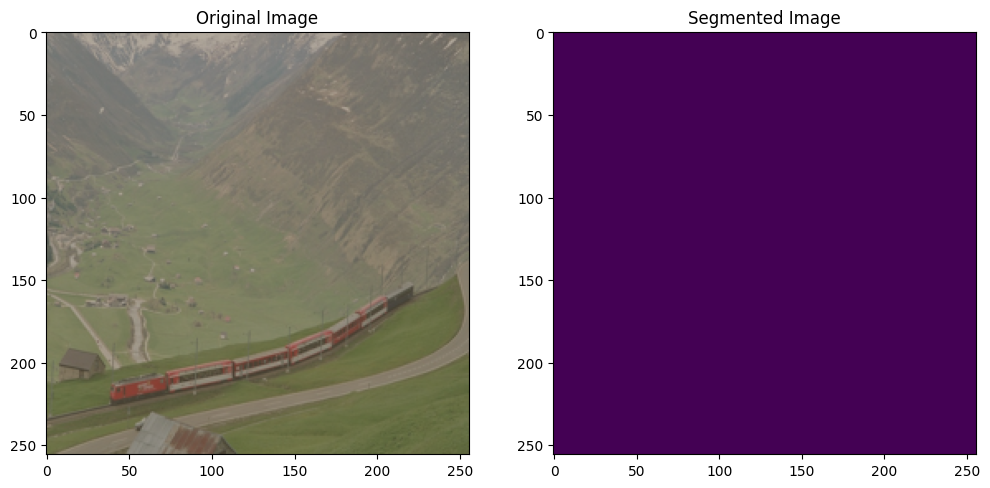

In [14]:
def denormalize(image):
    # Denormalize the image (assuming PyTorch normalization)
    image = image * torch.Tensor([0.229, 0.224, 0.225])[:, None, None]
    image = image + torch.Tensor([0.485, 0.456, 0.406])[:, None, None]
    return image

model.eval()
for i, (images, targets) in enumerate(testloader):
    targets = targets.long()  # Ensure targets are long type
    with torch.no_grad():
        print(f'input images shape {images.shape}')
        masks = model(images)
        print(f'masks shape {masks.shape}')

        # Convert predicted class scores to class labels
        predicted_masks = torch.argmax(masks, dim=1)  # Shape: (batch_size, height, width)

        # Take the first image in the batch for visualization
        img = predicted_masks[0].cpu().numpy()  # Convert tensor to numpy array
        print(img)

        # Also get the original image for comparison
        original_image = images[0]  # Shape: (channels, height, width)
        original_image = denormalize(original_image)  # Denormalize
        original_image = original_image.permute(1, 2, 0)  # Shape: (height, width, channels)
        original_image = original_image.cpu().numpy()  # Convert tensor to numpy array

        # Plot original image and the segmentation mask side by side
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(img)
        plt.title('Segmented Image')
        plt.show()
        break


input images shape torch.Size([32, 3, 256, 256])
torch.Size([32, 256, 256])
torch.Size([256, 256])


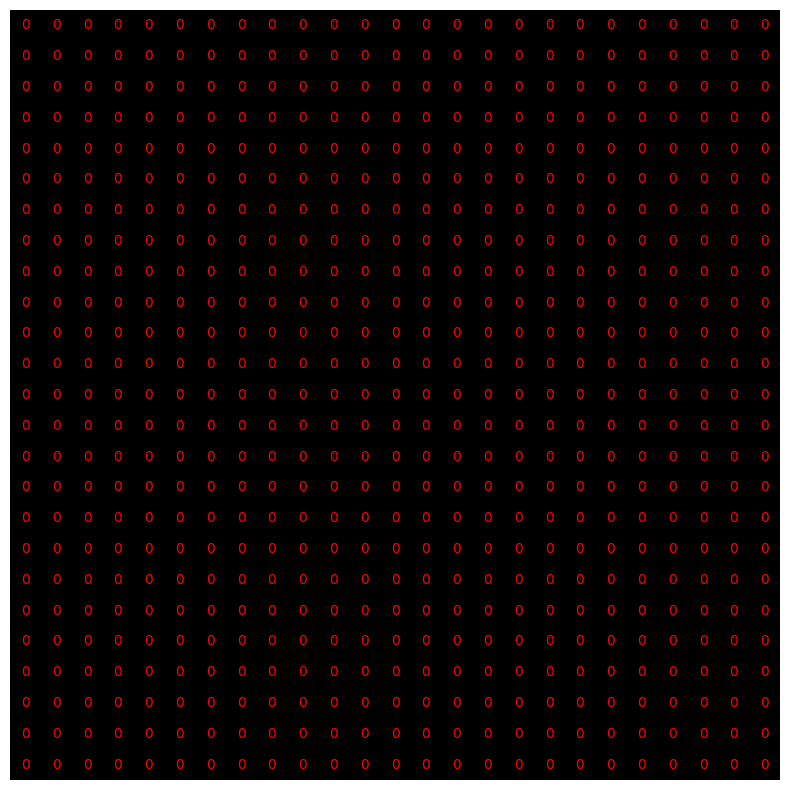

In [26]:
import torch
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

model.eval()
for i, (images, targets) in enumerate(testloader):
    targets = targets.long()  # Ensure targets are long type
    # Get an image and its corresponding mask
    img, mask = images[2], targets[2]

    with torch.no_grad():
        print(f'input images shape {images.shape}')
        masks = model(images)
        #mask = masks[0]
        #print(mask.shape)
        # Convert predicted class scores to class labels
        predicted_masks = torch.argmax(masks, dim=1)  # Shape: (batch_size, height, width)

        # Take the first image in the batch for visualization
        #img = predicted_masks[0].cpu().numpy()  # Convert tensor to numpy array
        print(predicted_masks.shape)
        mask = predicted_masks[0]

    # Convert the mask to a float tensor
    print(mask.shape)
    mask = mask.float()

    # Downsample the mask using MaxPool2d
    downsample = torch.nn.MaxPool2d(10, stride=10)
    downsampled_mask = downsample(mask.unsqueeze(0)).squeeze(0).squeeze(0)

    # Convert the downsampled mask tensor to a numpy array
    mask_np = downsampled_mask.numpy()


    # Plot the mask in grayscale
    plt.figure(figsize=(10, 10))
    plt.imshow(mask_np, cmap='gray')

    # Add the class index to each pixel
    for i in range(mask_np.shape[0]):
        for j in range(mask_np.shape[1]):
            #if mask_np[i, j] > 0:
            plt.text(j, i, int(mask_np[i, j]), ha='center', va='center', color='red')

    plt.axis('off')
    plt.show()
    break